<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [1]:
!rm -rf sample_data
!nvidia-smi

Wed May  5 17:04:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [2]:
from IPython.display import clear_output

#!pip install torch==1.7.1+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [ ]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [3]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/Ea5EziAZKiVGgvYIqubZk04BSQOx4B1IMXLqQu8Fc5nKOA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait = False)

In [ ]:
!rm checkpoint*

rm: cannot remove 'checkpoint*': No such file or directory


In [4]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/LVL4_OD",File) for File in os.listdir("./OpticDiscs/LVL4_OD") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/LVL0_OD",File) for File in os.listdir("./OpticDiscs/LVL0_OD") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "LVL0" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/LVL0_OD/201_p_31501_left.jpeg,1
1,./OpticDiscs/LVL0_OD/90_p_15315_left.jpeg,1
2,./OpticDiscs/LVL0_OD/179_p_28033_right.jpeg,1
3,./OpticDiscs/LVL0_OD/106_p_17901_right.jpeg,1
4,./OpticDiscs/LVL0_OD/245_p_38364_left.jpeg,1


In [ ]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/4270_left.jpeg,1
1,./OpticDiscs/Good images/26079_left.jpeg,1
2,./OpticDiscs/Good images/4998_right.jpeg,1
3,./OpticDiscs/Good images/21026_right.jpeg,1
4,./OpticDiscs/Good images/40631_left.jpeg,1


In [5]:
len(data)

396

#### Split data

In [6]:
from sklearn.model_selection import train_test_split

Train,Validation = train_test_split(data,test_size = 0.40,random_state = 65)
X_train = Train['imageFilename']
y_train = Train['class']
#Split data
X_validation, X_test, y_validation, y_test = train_test_split(Validation['imageFilename'], Validation['class'], test_size=0.50, random_state=65)


In [7]:
print("Datos de entrenamiento:")
print(y_train.value_counts())
print("Datos de validación:")
print(y_validation.value_counts())
print("Datos de test:")
print(y_test.value_counts())

Datos de entrenamiento:
0    122
1    115
Name: class, dtype: int64
Datos de validación:
0    40
1    39
Name: class, dtype: int64
Datos de test:
1    44
0    36
Name: class, dtype: int64


In [8]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
43,134_p_22678_right.jpeg,1
156,248_p_38725_right.jpeg,1
56,244_p_38232_right.jpeg,1
67,153_p_24171_right.jpeg,1
190,146_p_23548_right.jpeg,1


In [9]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [10]:
import torchvision.models as models
import torch
network_name = 'resnet18'
model = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
## Change efficientnet final layer
model.fc = torch.nn.Linear(in_features=512,out_features=2,bias = True)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11177538

In [15]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter,RandomResizedCrop,RandomPerspective,GaussianBlur
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),
                      RandomRotation(180),
                      RandomResizedCrop((224 ,224), scale=(0.7, 1.2)),
                      RandomPerspective(),
                      GaussianBlur((3,3))]) # Transformations for the training images

composed = Compose([Resize(224), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [17]:
try:
    model = torch.load('./checkpoint_b0_11.ph', map_location=device)
except:
    print("No Checkpoint loaded")

No Checkpoint loaded


In [18]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [19]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_validation)//batch_size):
        with torch.no_grad():

            X = X_validation.iloc[point*batch_size:(point+1)*batch_size]
            y = y_validation.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 2 Accuracy: 0.00000 Loss: 0.81104 :   0%|                            | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.50633 Loss: 0.80634 



Epoch: 3 Accuracy: 1.00000 Loss: 0.64047 :   1%|▏                   | 2/237 [00:00<00:14, 16.08it/s]

Validation -- Accuracy: 0.50633 Loss: 0.75690 



Epoch: 4 Accuracy: 1.00000 Loss: 0.64780 :   0%|                            | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.53165 Loss: 0.72554 



Epoch: 5 Accuracy: 0.50000 Loss: 0.62901 :   1%|▏                   | 2/237 [00:00<00:17, 13.22it/s]

Validation -- Accuracy: 0.50633 Loss: 0.74967 



Epoch: 6 Accuracy: 0.50000 Loss: 0.78811 :   1%|▏                   | 2/237 [00:00<00:17, 13.54it/s]

Validation -- Accuracy: 0.50633 Loss: 0.73266 



Epoch: 7 Accuracy: 1.00000 Loss: 0.62907 :   1%|▏                   | 2/237 [00:00<00:15, 14.96it/s]

Validation -- Accuracy: 0.51899 Loss: 0.72456 



Epoch: 8 Accuracy: 1.00000 Loss: 0.65387 :   0%|                            | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.59494 Loss: 0.70772 



Epoch: 9 Accuracy: 0.50000 Loss: 0.71232 :   1%|▏                   | 2/237 [00:00<00:18, 12.93it/s]

Validation -- Accuracy: 0.59494 Loss: 0.67324 



Epoch: 10 Accuracy: 0.50000 Loss: 0.61840 :   1%|▏                  | 2/237 [00:00<00:17, 13.19it/s]

Validation -- Accuracy: 0.56962 Loss: 0.67475 



Epoch: 11 Accuracy: 1.00000 Loss: 0.59655 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.62025 Loss: 0.61418 



Epoch: 12 Accuracy: 1.00000 Loss: 0.38996 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.70886 Loss: 0.60723 



Epoch: 13 Accuracy: 1.00000 Loss: 0.39822 :   1%|▏                  | 2/237 [00:00<00:16, 13.92it/s]

Validation -- Accuracy: 0.65823 Loss: 0.50778 



Epoch: 14 Accuracy: 1.00000 Loss: 0.39168 :   1%|▏                  | 2/237 [00:00<00:16, 14.33it/s]

Validation -- Accuracy: 0.62025 Loss: 0.40464 



Epoch: 15 Accuracy: 0.50000 Loss: 0.30586 :   1%|▏                  | 2/237 [00:00<00:16, 14.38it/s]

Validation -- Accuracy: 0.64557 Loss: 0.34974 



Epoch: 16 Accuracy: 0.50000 Loss: 0.61782 :   1%|▏                  | 2/237 [00:00<00:16, 14.52it/s]

Validation -- Accuracy: 0.59494 Loss: 0.27566 



Epoch: 17 Accuracy: 1.00000 Loss: 0.33915 :   1%|▏                  | 2/237 [00:00<00:16, 14.25it/s]

Validation -- Accuracy: 0.56962 Loss: 0.24102 



Epoch: 18 Accuracy: 1.00000 Loss: 0.48102 :   1%|▏                  | 2/237 [00:00<00:15, 14.88it/s]

Validation -- Accuracy: 0.60759 Loss: 0.23971 



Epoch: 19 Accuracy: 1.00000 Loss: 0.68341 :   1%|▏                  | 2/237 [00:00<00:17, 13.76it/s]

Validation -- Accuracy: 0.63291 Loss: 0.21843 



Epoch: 20 Accuracy: 1.00000 Loss: 0.27320 :   1%|▏                  | 2/237 [00:00<00:16, 13.87it/s]

Validation -- Accuracy: 0.62025 Loss: 0.19172 



Epoch: 21 Accuracy: 1.00000 Loss: 0.14658 :   1%|▏                  | 2/237 [00:00<00:17, 13.81it/s]

Validation -- Accuracy: 0.65823 Loss: 0.17998 



Epoch: 22 Accuracy: 1.00000 Loss: 0.12244 :   1%|▏                  | 2/237 [00:00<00:16, 14.35it/s]

Validation -- Accuracy: 0.62025 Loss: 0.15683 



Epoch: 23 Accuracy: 1.00000 Loss: 0.12444 :   1%|▏                  | 2/237 [00:00<00:16, 14.65it/s]

Validation -- Accuracy: 0.64557 Loss: 0.15559 



Epoch: 24 Accuracy: 1.00000 Loss: 0.17842 :   1%|▏                  | 2/237 [00:00<00:16, 14.60it/s]

Validation -- Accuracy: 0.67089 Loss: 0.15169 



Epoch: 25 Accuracy: 1.00000 Loss: 0.40146 :   1%|▏                  | 2/237 [00:00<00:16, 14.19it/s]

Validation -- Accuracy: 0.65823 Loss: 0.14813 



Epoch: 26 Accuracy: 1.00000 Loss: 0.17150 :   1%|▏                  | 2/237 [00:00<00:16, 14.27it/s]

Validation -- Accuracy: 0.63291 Loss: 0.12750 



Epoch: 27 Accuracy: 0.00000 Loss: 2.18391 :   1%|▏                  | 2/237 [00:00<00:15, 15.57it/s]

Validation -- Accuracy: 0.70886 Loss: 0.14695 



Epoch: 28 Accuracy: 1.00000 Loss: 0.22122 :   1%|▏                  | 2/237 [00:00<00:17, 13.54it/s]

Validation -- Accuracy: 0.70886 Loss: 0.13733 



Epoch: 29 Accuracy: 1.00000 Loss: 0.06919 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.74684 Loss: 0.13536 



Epoch: 30 Accuracy: 0.50000 Loss: 0.37423 :   1%|▏                  | 2/237 [00:00<00:16, 14.39it/s]

Validation -- Accuracy: 0.70886 Loss: 0.11860 



Epoch: 31 Accuracy: 1.00000 Loss: 0.06914 :   1%|▏                  | 2/237 [00:00<00:17, 13.39it/s]

Validation -- Accuracy: 0.72152 Loss: 0.10799 



Epoch: 32 Accuracy: 1.00000 Loss: 0.09043 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.75949 Loss: 0.11325 



Epoch: 33 Accuracy: 1.00000 Loss: 0.26321 :   1%|▏                  | 2/237 [00:00<00:16, 14.26it/s]

Validation -- Accuracy: 0.74684 Loss: 0.10745 



Epoch: 34 Accuracy: 0.50000 Loss: 0.07381 :   1%|▏                  | 2/237 [00:00<00:15, 14.78it/s]

Validation -- Accuracy: 0.70886 Loss: 0.09193 



Epoch: 35 Accuracy: 1.00000 Loss: 0.15736 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.79747 Loss: 0.10861 



Epoch: 36 Accuracy: 1.00000 Loss: 0.08108 :   1%|▏                  | 2/237 [00:00<00:17, 13.14it/s]

Validation -- Accuracy: 0.74684 Loss: 0.08695 



Epoch: 37 Accuracy: 1.00000 Loss: 0.10137 :   1%|▏                  | 2/237 [00:00<00:17, 13.08it/s]

Validation -- Accuracy: 0.73418 Loss: 0.09158 



Epoch: 38 Accuracy: 1.00000 Loss: 0.24813 :   1%|▏                  | 2/237 [00:00<00:16, 14.13it/s]

Validation -- Accuracy: 0.70886 Loss: 0.07498 



Epoch: 39 Accuracy: 1.00000 Loss: 0.07660 :   0%|                   | 1/237 [00:00<00:27,  8.57it/s]

Validation -- Accuracy: 0.72152 Loss: 0.08036 



Epoch: 40 Accuracy: 1.00000 Loss: 0.03908 :   1%|▏                  | 2/237 [00:00<00:17, 13.60it/s]

Validation -- Accuracy: 0.72152 Loss: 0.07846 



Epoch: 41 Accuracy: 0.50000 Loss: 0.46595 :   1%|▏                  | 2/237 [00:00<00:16, 14.54it/s]

Validation -- Accuracy: 0.74684 Loss: 0.07257 



Epoch: 42 Accuracy: 1.00000 Loss: 0.10881 :   1%|▏                  | 2/237 [00:00<00:16, 14.28it/s]

Validation -- Accuracy: 0.74684 Loss: 0.07808 



Epoch: 43 Accuracy: 1.00000 Loss: 0.07605 :   1%|▏                  | 2/237 [00:00<00:22, 10.64it/s]

Validation -- Accuracy: 0.73418 Loss: 0.07271 



Epoch: 44 Accuracy: 1.00000 Loss: 0.10655 :   1%|▏                  | 2/237 [00:00<00:16, 14.53it/s]

Validation -- Accuracy: 0.73418 Loss: 0.06850 



Epoch: 45 Accuracy: 1.00000 Loss: 0.14992 :   1%|▏                  | 2/237 [00:00<00:16, 14.38it/s]

Validation -- Accuracy: 0.73418 Loss: 0.06493 



Epoch: 46 Accuracy: 1.00000 Loss: 0.07251 :   1%|▏                  | 2/237 [00:00<00:16, 14.35it/s]

Validation -- Accuracy: 0.78481 Loss: 0.07505 



Epoch: 47 Accuracy: 1.00000 Loss: 0.08164 :   1%|▏                  | 2/237 [00:00<00:16, 14.18it/s]

Validation -- Accuracy: 0.78481 Loss: 0.07843 



Epoch: 48 Accuracy: 1.00000 Loss: 0.11831 :   1%|▏                  | 2/237 [00:00<00:17, 13.55it/s]

Validation -- Accuracy: 0.79747 Loss: 0.06940 



Epoch: 49 Accuracy: 1.00000 Loss: 0.53464 :   1%|▏                  | 2/237 [00:00<00:16, 14.56it/s]

Validation -- Accuracy: 0.75949 Loss: 0.05816 



Epoch: 50 Accuracy: 1.00000 Loss: 0.17653 :   1%|▏                  | 2/237 [00:00<00:15, 14.86it/s]

Validation -- Accuracy: 0.78481 Loss: 0.05125 



Epoch: 51 Accuracy: 1.00000 Loss: 0.28635 :   1%|▏                  | 2/237 [00:00<00:16, 13.98it/s]

Validation -- Accuracy: 0.75949 Loss: 0.04834 



Epoch: 52 Accuracy: 0.50000 Loss: 0.03547 :   1%|▏                  | 2/237 [00:00<00:15, 15.42it/s]

Validation -- Accuracy: 0.74684 Loss: 0.04715 



Epoch: 53 Accuracy: 1.00000 Loss: 0.03965 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.82278 Loss: 0.05000 



Epoch: 54 Accuracy: 1.00000 Loss: 0.05747 :   1%|▏                  | 2/237 [00:00<00:17, 13.51it/s]

Validation -- Accuracy: 0.78481 Loss: 0.04649 



Epoch: 55 Accuracy: 0.50000 Loss: 0.74272 :   1%|▏                  | 2/237 [00:00<00:15, 14.71it/s]

Validation -- Accuracy: 0.81013 Loss: 0.04486 



Epoch: 56 Accuracy: 0.50000 Loss: 0.93289 :   1%|▏                  | 2/237 [00:00<00:16, 13.86it/s]

Validation -- Accuracy: 0.79747 Loss: 0.04607 



Epoch: 57 Accuracy: 1.00000 Loss: 0.04014 :   1%|▏                  | 2/237 [00:00<00:16, 13.84it/s]

Validation -- Accuracy: 0.77215 Loss: 0.04217 



Epoch: 58 Accuracy: 1.00000 Loss: 0.04365 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.83544 Loss: 0.04396 



Epoch: 59 Accuracy: 1.00000 Loss: 0.05320 :   1%|▏                  | 2/237 [00:00<00:16, 14.47it/s]

Validation -- Accuracy: 0.82278 Loss: 0.04095 



Epoch: 60 Accuracy: 1.00000 Loss: 0.03418 :   1%|▏                  | 2/237 [00:00<00:16, 14.67it/s]

Validation -- Accuracy: 0.82278 Loss: 0.04183 



Epoch: 61 Accuracy: 1.00000 Loss: 0.07190 :   1%|▏                  | 2/237 [00:00<00:17, 13.77it/s]

Validation -- Accuracy: 0.79747 Loss: 0.04320 



Epoch: 62 Accuracy: 1.00000 Loss: 0.02685 :   1%|▏                  | 2/237 [00:00<00:17, 13.18it/s]

Validation -- Accuracy: 0.79747 Loss: 0.04285 



Epoch: 63 Accuracy: 1.00000 Loss: 0.02649 :   1%|▏                  | 2/237 [00:00<00:14, 15.79it/s]

Validation -- Accuracy: 0.83544 Loss: 0.03887 



Epoch: 64 Accuracy: 1.00000 Loss: 0.03009 :   1%|▏                  | 2/237 [00:00<00:16, 14.06it/s]

Validation -- Accuracy: 0.82278 Loss: 0.03795 



Epoch: 65 Accuracy: 0.50000 Loss: 1.21916 :   1%|▏                  | 2/237 [00:00<00:16, 14.61it/s]

Validation -- Accuracy: 0.77215 Loss: 0.03402 



Epoch: 66 Accuracy: 1.00000 Loss: 0.02275 :   1%|▏                  | 2/237 [00:00<00:17, 13.52it/s]

Validation -- Accuracy: 0.78481 Loss: 0.03449 



Epoch: 67 Accuracy: 1.00000 Loss: 0.04916 :   1%|▏                  | 2/237 [00:00<00:17, 13.36it/s]

Validation -- Accuracy: 0.79747 Loss: 0.03480 



Epoch: 68 Accuracy: 1.00000 Loss: 0.01685 :   1%|▏                  | 2/237 [00:00<00:16, 13.98it/s]

Validation -- Accuracy: 0.82278 Loss: 0.03544 



Epoch: 69 Accuracy: 1.00000 Loss: 0.01676 :   0%|                           | 0/237 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84810 Loss: 0.03280 



Epoch: 70 Accuracy: 1.00000 Loss: 0.01657 :   1%|▏                  | 2/237 [00:00<00:18, 12.84it/s]

Validation -- Accuracy: 0.79747 Loss: 0.03767 



Epoch: 71 Accuracy: 1.00000 Loss: 0.03277 :   1%|▏                  | 2/237 [00:00<00:15, 14.69it/s]

Validation -- Accuracy: 0.81013 Loss: 0.03012 



Epoch: 72 Accuracy: 1.00000 Loss: 0.03489 :   1%|▏                  | 2/237 [00:00<00:16, 14.40it/s]

Validation -- Accuracy: 0.83544 Loss: 0.03203 



Epoch: 73 Accuracy: 1.00000 Loss: 0.01824 :   1%|▏                  | 2/237 [00:00<00:17, 13.79it/s]

Validation -- Accuracy: 0.83544 Loss: 0.04028 



Epoch: 74 Accuracy: 1.00000 Loss: 0.01665 :   1%|▏                  | 2/237 [00:00<00:16, 14.32it/s]

Validation -- Accuracy: 0.83544 Loss: 0.03938 



Epoch: 75 Accuracy: 1.00000 Loss: 0.03249 :   1%|▏                  | 2/237 [00:00<00:17, 13.56it/s]

Validation -- Accuracy: 0.83544 Loss: 0.03521 



Epoch: 76 Accuracy: 1.00000 Loss: 0.28373 :   1%|▏                  | 2/237 [00:00<00:15, 15.11it/s]

Validation -- Accuracy: 0.82278 Loss: 0.02905 



Epoch: 77 Accuracy: 1.00000 Loss: 0.01555 :   1%|▏                  | 2/237 [00:00<00:16, 13.93it/s]

Validation -- Accuracy: 0.83544 Loss: 0.02816 



Epoch: 78 Accuracy: 1.00000 Loss: 0.01673 :   0%|                   | 1/237 [00:00<00:28,  8.42it/s]

Validation -- Accuracy: 0.84810 Loss: 0.02947 



Epoch: 79 Accuracy: 1.00000 Loss: 0.01427 :   1%|▏                  | 2/237 [00:00<00:16, 14.32it/s]

Validation -- Accuracy: 0.82278 Loss: 0.02662 



Epoch: 80 Accuracy: 1.00000 Loss: 0.12059 :   1%|▏                  | 2/237 [00:00<00:17, 13.28it/s]

Validation -- Accuracy: 0.84810 Loss: 0.02816 



Epoch: 81 Accuracy: 1.00000 Loss: 0.01876 :   0%|                   | 1/237 [00:00<00:43,  5.46it/s]

Validation -- Accuracy: 0.77215 Loss: 0.02383 



Epoch: 82 Accuracy: 1.00000 Loss: 0.08710 :   1%|▏                  | 2/237 [00:00<00:16, 14.42it/s]

Validation -- Accuracy: 0.84810 Loss: 0.03221 



Epoch: 83 Accuracy: 1.00000 Loss: 0.06811 :   1%|▏                  | 2/237 [00:00<00:17, 13.65it/s]

Validation -- Accuracy: 0.83544 Loss: 0.02678 



Epoch: 84 Accuracy: 1.00000 Loss: 0.00953 :   1%|▏                  | 2/237 [00:00<00:15, 14.92it/s]

Validation -- Accuracy: 0.79747 Loss: 0.02400 



Epoch: 85 Accuracy: 1.00000 Loss: 0.05422 :   1%|▏                  | 2/237 [00:00<00:16, 14.29it/s]

Validation -- Accuracy: 0.82278 Loss: 0.02191 



Epoch: 86 Accuracy: 1.00000 Loss: 0.00934 :   1%|▏                  | 2/237 [00:00<00:15, 14.92it/s]

Validation -- Accuracy: 0.77215 Loss: 0.01822 



Epoch: 87 Accuracy: 1.00000 Loss: 0.01382 :   1%|▏                  | 2/237 [00:00<00:17, 13.13it/s]

Validation -- Accuracy: 0.79747 Loss: 0.02152 



Epoch: 88 Accuracy: 1.00000 Loss: 0.03754 :   1%|▏                  | 2/237 [00:00<00:18, 12.73it/s]

Validation -- Accuracy: 0.79747 Loss: 0.02060 



Epoch: 89 Accuracy: 1.00000 Loss: 0.00842 :   1%|▏                  | 2/237 [00:00<00:16, 14.15it/s]

Validation -- Accuracy: 0.78481 Loss: 0.02042 



Epoch: 90 Accuracy: 1.00000 Loss: 0.04661 :   1%|▏                  | 2/237 [00:00<00:16, 14.34it/s]

Validation -- Accuracy: 0.83544 Loss: 0.02168 



Epoch: 91 Accuracy: 1.00000 Loss: 0.53596 :   1%|▏                  | 2/237 [00:00<00:15, 15.21it/s]

Validation -- Accuracy: 0.79747 Loss: 0.01932 



Epoch: 92 Accuracy: 1.00000 Loss: 0.01327 :   1%|▏                  | 2/237 [00:00<00:15, 14.71it/s]

Validation -- Accuracy: 0.78481 Loss: 0.01993 



Epoch: 93 Accuracy: 1.00000 Loss: 0.02251 :   1%|▏                  | 2/237 [00:00<00:17, 13.66it/s]

Validation -- Accuracy: 0.81013 Loss: 0.01988 



Epoch: 94 Accuracy: 1.00000 Loss: 0.01325 :   1%|▏                  | 2/237 [00:00<00:16, 14.02it/s]

Validation -- Accuracy: 0.82278 Loss: 0.01871 



Epoch: 95 Accuracy: 1.00000 Loss: 0.02193 :   1%|▏                  | 2/237 [00:00<00:17, 13.38it/s]

Validation -- Accuracy: 0.79747 Loss: 0.01921 



Epoch: 96 Accuracy: 1.00000 Loss: 0.01119 :   1%|▏                  | 2/237 [00:00<00:17, 13.38it/s]

Validation -- Accuracy: 0.79747 Loss: 0.01855 



Epoch: 97 Accuracy: 1.00000 Loss: 0.05280 :   1%|▏                  | 2/237 [00:00<00:17, 13.45it/s]

Validation -- Accuracy: 0.79747 Loss: 0.01980 



Epoch: 98 Accuracy: 1.00000 Loss: 0.04990 :   1%|▏                  | 2/237 [00:00<00:15, 14.82it/s]

Validation -- Accuracy: 0.77215 Loss: 0.01682 



Epoch: 99 Accuracy: 1.00000 Loss: 0.01727 :   1%|▏                  | 2/237 [00:00<00:16, 13.97it/s]

Validation -- Accuracy: 0.84810 Loss: 0.01938 



Epoch: 100 Accuracy: 1.00000 Loss: 0.01957 :   1%|▏                 | 2/237 [00:00<00:17, 13.51it/s]

Validation -- Accuracy: 0.81013 Loss: 0.01864 



Epoch: 100 Accuracy: 0.95781 Loss: 0.01666 : 100%|████████████████| 237/237 [00:18<00:00, 13.09it/s]


Validation -- Accuracy: 0.83544 Loss: 0.01831 



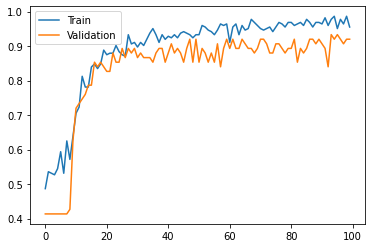

In [ ]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

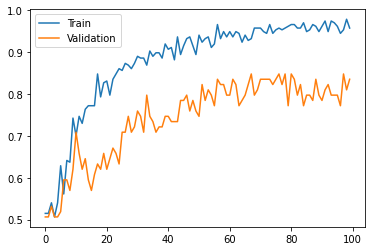

In [20]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [ ]:
!ls

checkpoint_resnet18_10_0.62667.ph  checkpoint_resnet18_23_0.88000.ph
checkpoint_resnet18_1_0.41333.ph   checkpoint_resnet18_26_0.89333.ph
checkpoint_resnet18_11_0.72000.ph  checkpoint_resnet18_42_0.90667.ph
checkpoint_resnet18_12_0.73333.ph  checkpoint_resnet18_48_0.92000.ph
checkpoint_resnet18_13_0.74667.ph  checkpoint_resnet18_9_0.42667.ph
checkpoint_resnet18_14_0.76000.ph  checkpoint_resnet18_94_0.93333.ph
checkpoint_resnet18_15_0.78667.ph  OpticDiscs
checkpoint_resnet18_17_0.85333.ph  test_data.csv


In [ ]:
torch.save(model,"checkpoint.ph")

In [ ]:
for c in y:
  print(c)

1


## Evaluation

In [ ]:
model = torch.load('checkpoint_resnet18_23_0.88000.ph')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
predicted = []
true_values = []
all_predicted = []
all_true = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        all_predicted.append(outputs.cpu().detach().numpy()[0][1])
        all_true.append(y_true.cpu().detach().numpy()[0])
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [ ]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [ ]:
confusion_matrix(true_values, predicted)

array([[29,  8],
       [ 4, 34]])

0.9139402560455191


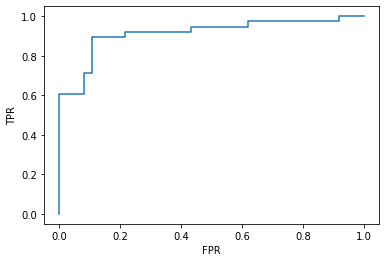

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

ns_fpr, ns_tpr, _ = roc_curve(all_true, all_predicted)
plt.plot(ns_fpr,ns_tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print(roc_auc_score(all_true, all_predicted))

In [ ]:
!mkdir Results
roc_data = pd.DataFrame(data = {"ns_fpr":ns_fpr,"ns_tpr":ns_tpr})
roc_data.to_csv("./Results/"+network_name+".csv")